In [23]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [24]:
random_state = 42


In [25]:
df = pd.read_csv('./data.csv')

df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [26]:
from sklearn.preprocessing import StandardScaler


def standardize_data(X: pd.DataFrame) -> pd.DataFrame:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    return pd.DataFrame(X_scaled, columns=X.columns)

In [27]:
features = [
    'season',
    'yr',
    'mnth',
    'hr',
    'holiday',
    'weekday',
    'workingday',
    'weathersit',
    'temp',
    'atemp',
    'hum',
    'windspeed',
]

X = df[features]
X = standardize_data(X)
y = df['cnt']

In [28]:
y

0         16
1         40
2         32
3         13
4          1
        ... 
10881    336
10882    241
10883    168
10884    129
10885     88
Name: cnt, Length: 10886, dtype: int64

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Architecture and experiments

In [30]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [31]:
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using {device} device")

Using mps device


In [32]:
batch_size = 256

train_dataset = TensorDataset(
    torch.from_numpy(X_train.to_numpy().astype('float32')), 
    torch.from_numpy(y_train.to_numpy().astype('float32')))

test_dataset = TensorDataset(
    torch.from_numpy(X_test.to_numpy().astype('float32')),
    torch.from_numpy(y_test.to_numpy().astype('float32')))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [33]:
def rmsle(y_true, y_pred):
    n = len(y_true)
    y_true = y_true.reshape(-1, 1)
    msle = np.mean([(np.log(max(y_pred[i], 0) + 1) -
                   np.log(y_true[i] + 1)) ** 2.0 for i in range(n)])
    return np.sqrt(msle)


class RMSLELoss(nn.Module):
    def __init__(self):
        super(RMSLELoss, self).__init__()

    def forward(self, y_pred, y_true):
        y_pred = torch.clamp(y_pred, min=0)
        loss = torch.sqrt(torch.mean(
            (torch.log1p(y_pred) - torch.log1p(y_true)) ** 2))
        return loss

In [34]:
# criterion = nn.MSELoss()
criterion = RMSLELoss()

def train_loop(dataloader, model, optimizer):
    model.train()

    total_loss = 0
    total_batches = len(dataloader)

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        y = y.view_as(pred)

        loss = criterion(pred, y)
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        total_loss += loss.item()

    return total_loss/total_batches


def test_loop(dataloader, model):
    model.eval()

    total_loss = 0
    total_batches = len(dataloader)

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            pred = model(X)
            y = y.view_as(pred)

            total_loss += criterion(pred, y).item()

    return total_loss/total_batches

In [35]:
def train_and_evaluate(model, epochs, learning_rate=0.01):
    train_losses = []
    test_losses = []

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for t in range(epochs):
        avg_train_loss = train_loop(train_dataloader, model, optimizer)
        avg_test_loss = test_loop(test_dataloader, model)

        train_losses.append(avg_train_loss)
        test_losses.append(avg_test_loss)

        print(f"Epoch {t+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {avg_test_loss:.4f}")

    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs + 1), test_losses, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Testing Loss Curves')
    plt.legend()
    plt.show()

Epoch 1/200 - Train Loss: 2.0897 - Test Loss: 1.2787
Epoch 2/200 - Train Loss: 1.1260 - Test Loss: 1.0501
Epoch 3/200 - Train Loss: 1.0103 - Test Loss: 0.9964
Epoch 4/200 - Train Loss: 0.9736 - Test Loss: 0.9735
Epoch 5/200 - Train Loss: 0.9561 - Test Loss: 0.9599
Epoch 6/200 - Train Loss: 0.9452 - Test Loss: 0.9501
Epoch 7/200 - Train Loss: 0.9364 - Test Loss: 0.9419
Epoch 8/200 - Train Loss: 0.9284 - Test Loss: 0.9348
Epoch 9/200 - Train Loss: 0.9212 - Test Loss: 0.9279
Epoch 10/200 - Train Loss: 0.9144 - Test Loss: 0.9216
Epoch 11/200 - Train Loss: 0.9079 - Test Loss: 0.9151
Epoch 12/200 - Train Loss: 0.9016 - Test Loss: 0.9088
Epoch 13/200 - Train Loss: 0.8952 - Test Loss: 0.9021
Epoch 14/200 - Train Loss: 0.8890 - Test Loss: 0.8960
Epoch 15/200 - Train Loss: 0.8835 - Test Loss: 0.8904
Epoch 16/200 - Train Loss: 0.8783 - Test Loss: 0.8849
Epoch 17/200 - Train Loss: 0.8731 - Test Loss: 0.8795
Epoch 18/200 - Train Loss: 0.8683 - Test Loss: 0.8746
Epoch 19/200 - Train Loss: 0.8642 - T

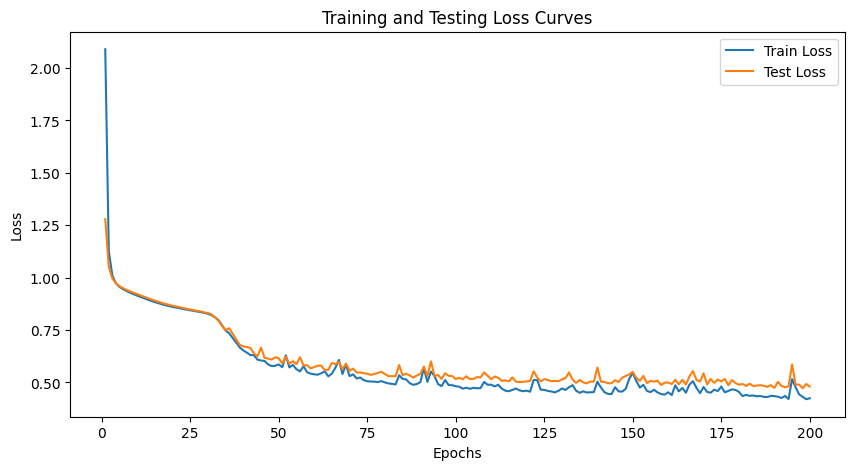

In [36]:
class NeuralNetwork1(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.activ = nn.ReLU()

        self.lin1 = nn.Linear(12, 512)
        self.lin2 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.activ(x)

        x = self.lin2(x)

        return x


model1 = NeuralNetwork1()
model1.to(device)

train_and_evaluate(model1, 200)

Epoch 1/200 - Train Loss: 2.4128 - Test Loss: 1.5724
Epoch 2/200 - Train Loss: 1.3675 - Test Loss: 1.2605
Epoch 3/200 - Train Loss: 1.1854 - Test Loss: 1.1337
Epoch 4/200 - Train Loss: 1.0875 - Test Loss: 1.0595
Epoch 5/200 - Train Loss: 1.0276 - Test Loss: 1.0160
Epoch 6/200 - Train Loss: 0.9898 - Test Loss: 0.9869
Epoch 7/200 - Train Loss: 0.9642 - Test Loss: 0.9653
Epoch 8/200 - Train Loss: 0.9453 - Test Loss: 0.9468
Epoch 9/200 - Train Loss: 0.9293 - Test Loss: 0.9297
Epoch 10/200 - Train Loss: 0.9144 - Test Loss: 0.9146
Epoch 11/200 - Train Loss: 0.9002 - Test Loss: 0.9007
Epoch 12/200 - Train Loss: 0.8864 - Test Loss: 0.8871
Epoch 13/200 - Train Loss: 0.8722 - Test Loss: 0.8731
Epoch 14/200 - Train Loss: 0.8570 - Test Loss: 0.8579
Epoch 15/200 - Train Loss: 0.8403 - Test Loss: 0.8412
Epoch 16/200 - Train Loss: 0.8218 - Test Loss: 0.8228
Epoch 17/200 - Train Loss: 0.8016 - Test Loss: 0.8024
Epoch 18/200 - Train Loss: 0.7800 - Test Loss: 0.7807
Epoch 19/200 - Train Loss: 0.7574 - T

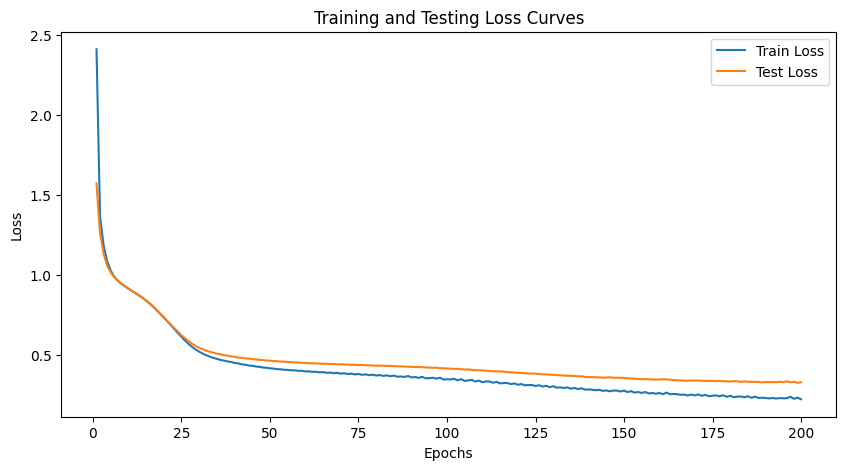

In [37]:
class NeuralNetwork2(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.activ = nn.ReLU()

        self.lin1 = nn.Linear(12, 512)
        self.lin2 = nn.Linear(512, 512)
        self.lin3 = nn.Linear(512, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.activ(x)

        x = self.lin2(x)
        x = self.activ(x)

        x = self.lin3(x)

        return x


model2 = NeuralNetwork2()
model2.to(device)

train_and_evaluate(model2, 200, 0.001)

Epoch 1/200 - Train Loss: 3.1296 - Test Loss: 2.2017
Epoch 2/200 - Train Loss: 1.7969 - Test Loss: 1.5316
Epoch 3/200 - Train Loss: 1.3746 - Test Loss: 1.2816
Epoch 4/200 - Train Loss: 1.2069 - Test Loss: 1.1654
Epoch 5/200 - Train Loss: 1.1202 - Test Loss: 1.0990
Epoch 6/200 - Train Loss: 1.0670 - Test Loss: 1.0585
Epoch 7/200 - Train Loss: 1.0324 - Test Loss: 1.0320
Epoch 8/200 - Train Loss: 1.0085 - Test Loss: 1.0128
Epoch 9/200 - Train Loss: 0.9911 - Test Loss: 0.9981
Epoch 10/200 - Train Loss: 0.9780 - Test Loss: 0.9870
Epoch 11/200 - Train Loss: 0.9678 - Test Loss: 0.9785
Epoch 12/200 - Train Loss: 0.9599 - Test Loss: 0.9716
Epoch 13/200 - Train Loss: 0.9533 - Test Loss: 0.9658
Epoch 14/200 - Train Loss: 0.9477 - Test Loss: 0.9605
Epoch 15/200 - Train Loss: 0.9427 - Test Loss: 0.9555
Epoch 16/200 - Train Loss: 0.9379 - Test Loss: 0.9507
Epoch 17/200 - Train Loss: 0.9332 - Test Loss: 0.9457
Epoch 18/200 - Train Loss: 0.9285 - Test Loss: 0.9405
Epoch 19/200 - Train Loss: 0.9234 - T

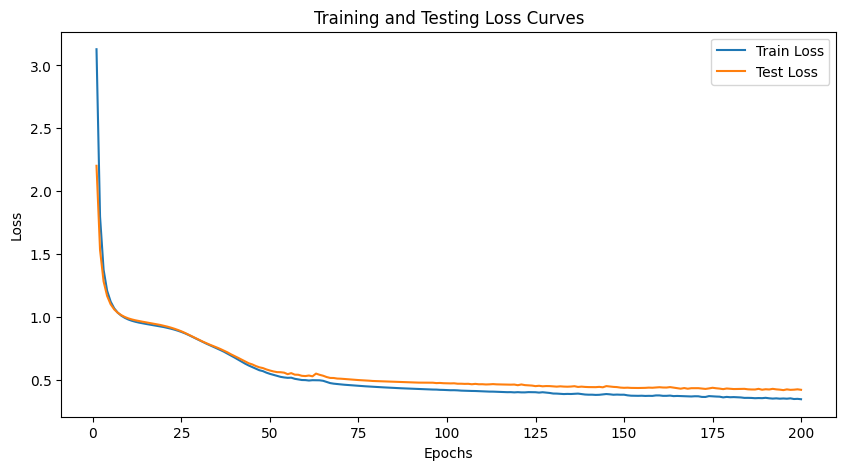

In [38]:
class NeuralNetwork3(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.activ = nn.ReLU()

        self.lin1 = nn.Linear(12, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.activ(x)

        x = self.lin2(x)
        x = self.activ(x)

        x = self.lin3(x)

        return x


model3 = NeuralNetwork3()
model3.to(device)

train_and_evaluate(model3, 200, 0.001)

Epoch 1/500 - Train Loss: 2.5040 - Test Loss: 1.3864
Epoch 2/500 - Train Loss: 1.2793 - Test Loss: 1.1730
Epoch 3/500 - Train Loss: 1.0997 - Test Loss: 1.0431
Epoch 4/500 - Train Loss: 1.0001 - Test Loss: 0.9714
Epoch 5/500 - Train Loss: 0.9442 - Test Loss: 0.9319
Epoch 6/500 - Train Loss: 0.9104 - Test Loss: 0.9038
Epoch 7/500 - Train Loss: 0.8815 - Test Loss: 0.8744
Epoch 8/500 - Train Loss: 0.8500 - Test Loss: 0.8405
Epoch 9/500 - Train Loss: 0.8144 - Test Loss: 0.8023
Epoch 10/500 - Train Loss: 0.7778 - Test Loss: 0.7652
Epoch 11/500 - Train Loss: 0.7425 - Test Loss: 0.7312
Epoch 12/500 - Train Loss: 0.7067 - Test Loss: 0.7003
Epoch 13/500 - Train Loss: 0.6666 - Test Loss: 0.6621
Epoch 14/500 - Train Loss: 0.6202 - Test Loss: 0.6189
Epoch 15/500 - Train Loss: 0.5689 - Test Loss: 0.5715
Epoch 16/500 - Train Loss: 0.5218 - Test Loss: 0.5369
Epoch 17/500 - Train Loss: 0.4945 - Test Loss: 0.5218
Epoch 18/500 - Train Loss: 0.4801 - Test Loss: 0.5080
Epoch 19/500 - Train Loss: 0.4681 - T

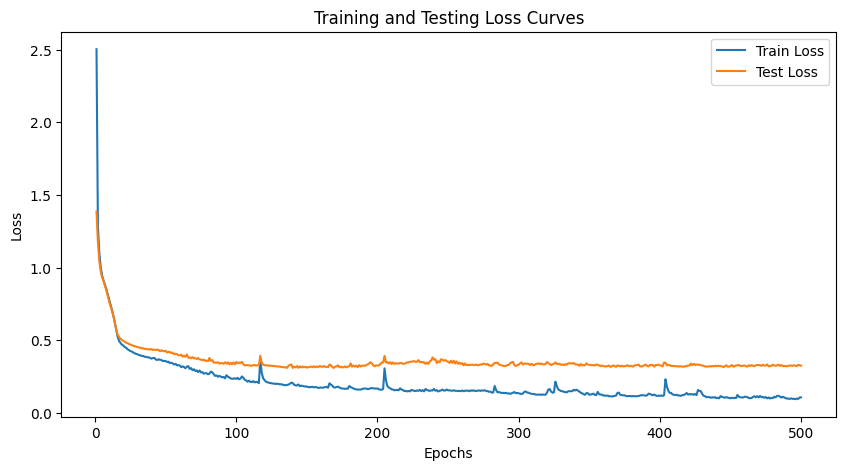

In [41]:
class NeuralNetwork4(nn.Module):
    def __init__(self, ):
        super().__init__()
        self.activ = nn.ReLU()

        self.lin1 = nn.Linear(12, 256)
        self.lin2 = nn.Linear(256, 256)
        self.lin3 = nn.Linear(256, 256)
        self.lin4 = nn.Linear(256, 1)

    def forward(self, x):
        x = self.lin1(x)
        x = self.activ(x)

        x = self.lin2(x)
        x = self.activ(x)

        x = self.lin3(x)
        x = self.activ(x)

        x = self.lin4(x)

        return x


model4 = NeuralNetwork4()
model4.to(device)

train_and_evaluate(model4, 500, 0.001)

In [ ]:
model = model4
sample = 10

with torch.no_grad():
    for x, y in zip(X_test[:sample].to_numpy(), y_test[:sample].to_numpy()):
        x = torch.from_numpy(x.astype('float32')).to(device)
        pred = model(x).item()

        print("Expected: ", y, "Predicted: ", pred)

Expected:  64 Predicted:  80.20870971679688
Expected:  33 Predicted:  30.9588623046875
Expected:  3 Predicted:  4.175559997558594
Expected:  620 Predicted:  668.5875854492188
Expected:  70 Predicted:  84.80586242675781
Expected:  43 Predicted:  32.70490646362305
Expected:  29 Predicted:  13.456013679504395
Expected:  160 Predicted:  147.7429962158203
Expected:  326 Predicted:  259.53875732421875
Expected:  3 Predicted:  5.4009552001953125


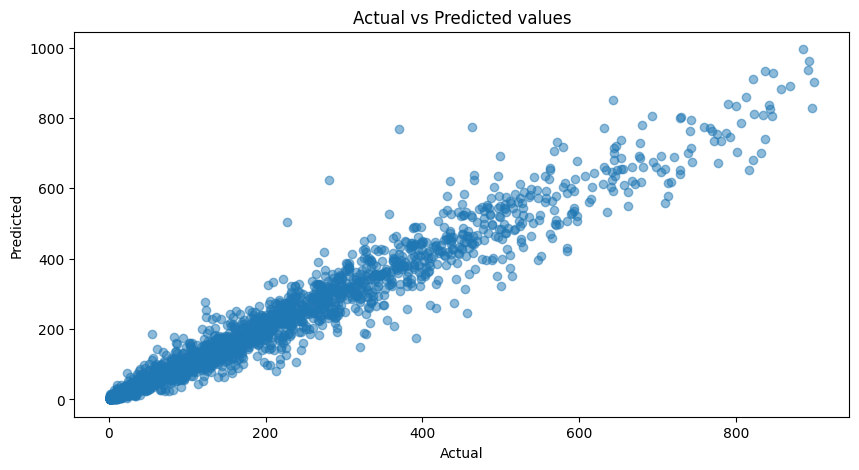

In [43]:
model = model4

# plot the predicted values against the actual values

with torch.no_grad():
    tensor = torch.from_numpy(X_test.to_numpy().astype('float32')).to(device)
    y_pred = model(tensor).cpu().numpy()
    y_test = y_test.to_numpy()

    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted values')
    plt.show()

## Save the results

In [ ]:
model = model4

In [ ]:
eval_df = pd.read_csv('./evaluation_data.csv')
eval_df.head()

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,2011-01-20,1,0,1,0,0,4,1,1,0.26,0.2273,0.56,0.3881
1,2011-01-20,1,0,1,1,0,4,1,1,0.26,0.2727,0.56,0.0000
2,2011-01-20,1,0,1,2,0,4,1,1,0.26,0.2727,0.56,0.0000
3,2011-01-20,1,0,1,3,0,4,1,1,0.26,0.2576,0.56,0.1642
4,2011-01-20,1,0,1,4,0,4,1,1,0.26,0.2576,0.56,0.1642


In [ ]:
X_eval = eval_df[features]

X_eval = standardize_data(X_eval)

X_eval

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed
0,-1.368527,-1.007265,-1.622849,-1.671785,-0.17315,0.493328,0.676844,-0.673687,-1.235966,-1.440193,-0.421172,1.620888
1,-1.368527,-1.007265,-1.622849,-1.527109,-0.17315,0.493328,0.676844,-0.673687,-1.235966,-1.181711,-0.421172,-1.531139
2,-1.368527,-1.007265,-1.622849,-1.382433,-0.17315,0.493328,0.676844,-0.673687,-1.235966,-1.181711,-0.421172,-1.531139
3,-1.368527,-1.007265,-1.622849,-1.237757,-0.17315,0.493328,0.676844,-0.673687,-1.235966,-1.267682,-0.421172,-0.197558
4,-1.368527,-1.007265,-1.622849,-1.093081,-0.17315,0.493328,0.676844,-0.673687,-1.235966,-1.267682,-0.421172,-0.197558
...,...,...,...,...,...,...,...,...,...,...,...,...
6488,-1.368527,0.992787,1.584898,1.077060,-0.17315,-1.004884,0.676844,0.868714,-1.235966,-1.267682,-0.213831,-0.197558
6489,-1.368527,0.992787,1.584898,1.221736,-0.17315,-1.004884,0.676844,0.868714,-1.235966,-1.267682,-0.213831,-0.197558
6490,-1.368527,0.992787,1.584898,1.366412,-0.17315,-1.004884,0.676844,-0.673687,-1.235966,-1.267682,-0.213831,-0.197558
6491,-1.368527,0.992787,1.584898,1.511088,-0.17315,-1.004884,0.676844,-0.673687,-1.235966,-1.181711,-0.421172,-0.440396


In [ ]:
eval_tensor = torch.from_numpy(X_eval.to_numpy().astype('float32'))

with torch.no_grad():
    preds = model(eval_tensor.to(device)).cpu().numpy()

preds_df = pd.DataFrame(preds, columns=['cnt'])
preds_df.to_csv('predictions.csv', index=False, header=False)

preds_df

,cnt
0,13.360838
1,5.375211
2,1.592975
3,2.044612
4,2.670311
...,...
6488,448.533295
6489,497.059631
6490,399.251587
6491,277.943665
